# DIAYN

In [1]:
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import numpy as np
from network_utils import np2torch

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_util import make_vec_env
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

In [6]:
NUM_SKILLS = 10

class SkillDist(nn.Module):
    def __init__(self, num_skills=NUM_SKILLS):
        super(SkillDist, self).__init__()

        self.num_skills = num_skills
        self.p = 1 / num_skills
        self.p_ = torch.tensor([self.p])
        self.dist = torch.distributions.Categorical(probs = torch.ones(num_skills) * self.p)

    def sample(self):
        return self.dist.sample()

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        nn.init.uniform_(self.fc1.weight, -0.01, 0.01)
        nn.init.uniform_(self.fc2.weight, -0.01, 0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: Env):
        super(CustomEnvWrapper, self).__init__(env)
        self.discriminator = Discriminator(input_size=env.observation_space.shape[0], hidden_size=128, output_size=NUM_SKILLS)
        self.optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)

        self.skill_dist = SkillDist()
        self.skill = self.skill_dist.sample()

        low = np.append(self.observation_space.low, -np.inf)
        high = np.append(self.observation_space.high, np.inf)
        self.observation_space = Box(low, high, dtype=np.float32)

        self.rewards = []
        self.loss = []
    
    def reset(self, seed=137):
        state = self.env.reset(seed=seed)
        self.skill = self.skill_dist.sample()
        new_state = np.append(state[0], self.skill.item())
        return (new_state, state[1])

    def step(self, action):
        state, reward, done, info, _ = self.env.step(action)
        reward = self.custom_reward_function(action, state, reward)

        self.rewards.append(reward)

        state = np.append(state, self.skill.item())

        # Change skill if new trajectory
        if done:
            self.skill = self.skill_dist.sample()

        return state, reward, done, info, _
    
    def custom_reward_function(self, action, state, original_reward):
        a = torch.log(self.discriminator(np2torch(state)))[self.skill.item()]
        b = torch.log(self.skill_dist.p_)

        # print(a_, a, b)

        r = a - b

        f = -a

        self.loss.append(a.item())

        self.optimizer.zero_grad()
        f.backward()
        self.optimizer.step()

        r_ = r.detach().numpy()

        return r_
    
    def cur_skill(self):
        return self.skill.item()

In [7]:
# DIAYN on PPO
env = gym.make("HalfCheetah-v4")
env = CustomEnvWrapper(env)

model = PPO(
    "MlpPolicy",  # Use the Multi-Layer Perceptron (MLP) policy
    env,  # The environment
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,  # Set to 1 to enable verbose output
)
model.learn(total_timesteps=100000, progress_bar=True)
model.save("diayn_ppo_cheetah_big3")

all_rewards = env.rewards
all_loss = env.loss
del model # remove to demonstrate saving and loading

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.88e+03 |
| time/              |          |
|    fps             | 1564     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 1001        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020916067 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.68       |
|    explained_variance   | 0.000163    |
|    learning_rate        | 0.0003      |
|    loss                 | 328         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0167     |
|    std                  | 1.05        |
|    value_loss           | 906         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.3e+03    |
| time/                   |            |
|    fps                  | 906        |
|    iterations           | 3          |
|    time_elapsed         | 6          |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 0.02351991 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.97      |
|    explained_variance   | 0.178      |
|    learning_rate        | 0.0003     |
|    loss                 | 166        |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.016     |
|    std                  | 1.11       |
|    value_loss           | 461        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.43e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 4           |
|    time_elapsed         | 8           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.033426594 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.32       |
|    explained_variance   | -0.171      |
|    learning_rate        | 0.0003      |
|    loss                 | 196         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.19        |
|    value_loss           | 560         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 954         |
|    iterations           | 5           |
|    time_elapsed         | 10          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.021611573 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.73       |
|    explained_variance   | 0.00092     |
|    learning_rate        | 0.0003      |
|    loss                 | 325         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.26        |
|    value_loss           | 880         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.3e+03   |
| time/                   |           |
|    fps                  | 972       |
|    iterations           | 6         |
|    time_elapsed         | 12        |
|    total_timesteps      | 12288     |
| train/                  |           |
|    approx_kl            | 0.0433755 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -10.1     |
|    explained_variance   | -0.00409  |
|    learning_rate        | 0.0003    |
|    loss                 | 177       |
|    n_updates            | 50        |
|    policy_gradient_loss | -0.00956  |
|    std                  | 1.37      |
|    value_loss           | 389       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.43e+03    |
| time/                   |             |
|    fps                  | 991         |
|    iterations           | 7           |
|    time_elapsed         | 14          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.009704589 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | -0.0304     |
|    learning_rate        | 0.0003      |
|    loss                 | 200         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00963    |
|    std                  | 1.41        |
|    value_loss           | 568         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.45e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 8            |
|    time_elapsed         | 16           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0097995605 |
|    clip_fraction        | 0.0425       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.7        |
|    explained_variance   | -7.27e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 280          |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.0118      |
|    std                  | 1.45         |
|    value_loss           | 649          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.27e+03    |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 9           |
|    time_elapsed         | 17          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.048332732 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.1       |
|    explained_variance   | 1.5e-05     |
|    learning_rate        | 0.0003      |
|    loss                 | 495         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0128     |
|    std                  | 1.58        |
|    value_loss           | 1.84e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.1e+03     |
| time/                   |             |
|    fps                  | 1046        |
|    iterations           | 10          |
|    time_elapsed         | 19          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008762978 |
|    clip_fraction        | 0.069       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | 0.00285     |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0154     |
|    std                  | 1.61        |
|    value_loss           | 440         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.06e+03   |
| time/                   |            |
|    fps                  | 1056       |
|    iterations           | 11         |
|    time_elapsed         | 21         |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.00818824 |
|    clip_fraction        | 0.0245     |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.4      |
|    explained_variance   | -0.161     |
|    learning_rate        | 0.0003     |
|    loss                 | 224        |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0089    |
|    std                  | 1.65       |
|    value_loss           | 349        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.03e+03    |
| time/                   |             |
|    fps                  | 1066        |
|    iterations           | 12          |
|    time_elapsed         | 23          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010525269 |
|    clip_fraction        | 0.0376      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.000198    |
|    learning_rate        | 0.0003      |
|    loss                 | 95          |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00922    |
|    std                  | 1.71        |
|    value_loss           | 258         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 902         |
| time/                   |             |
|    fps                  | 1078        |
|    iterations           | 13          |
|    time_elapsed         | 24          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.010861453 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.000897    |
|    learning_rate        | 0.0003      |
|    loss                 | 312         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.77        |
|    value_loss           | 757         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 896          |
| time/                   |              |
|    fps                  | 1090         |
|    iterations           | 14           |
|    time_elapsed         | 26           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0051944214 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -12          |
|    explained_variance   | 0.35         |
|    learning_rate        | 0.0003       |
|    loss                 | 30           |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00821     |
|    std                  | 1.81         |
|    value_loss           | 99.7         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 852          |
| time/                   |              |
|    fps                  | 1097         |
|    iterations           | 15           |
|    time_elapsed         | 27           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0007254982 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.1        |
|    explained_variance   | 0.62         |
|    learning_rate        | 0.0003       |
|    loss                 | 193          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00313     |
|    std                  | 1.82         |
|    value_loss           | 442          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 824         |
| time/                   |             |
|    fps                  | 1105        |
|    iterations           | 16          |
|    time_elapsed         | 29          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.007088471 |
|    clip_fraction        | 0.0352      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.2       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 282         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.87        |
|    value_loss           | 522         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 803         |
| time/                   |             |
|    fps                  | 1111        |
|    iterations           | 17          |
|    time_elapsed         | 31          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011935297 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.4       |
|    explained_variance   | -0.194      |
|    learning_rate        | 0.0003      |
|    loss                 | 79.9        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0124     |
|    std                  | 1.93        |
|    value_loss           | 216         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 814         |
| time/                   |             |
|    fps                  | 1117        |
|    iterations           | 18          |
|    time_elapsed         | 32          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.004769842 |
|    clip_fraction        | 0.0115      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.5       |
|    explained_variance   | 0.0269      |
|    learning_rate        | 0.0003      |
|    loss                 | 50.1        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00715    |
|    std                  | 1.97        |
|    value_loss           | 182         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 772         |
| time/                   |             |
|    fps                  | 1122        |
|    iterations           | 19          |
|    time_elapsed         | 34          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.008033412 |
|    clip_fraction        | 0.0225      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.6       |
|    explained_variance   | 0.353       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.3        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00802    |
|    std                  | 2.03        |
|    value_loss           | 253         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 739        |
| time/                   |            |
|    fps                  | 1128       |
|    iterations           | 20         |
|    time_elapsed         | 36         |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.00873415 |
|    clip_fraction        | 0.0271     |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.8      |
|    explained_variance   | -0.166     |
|    learning_rate        | 0.0003     |
|    loss                 | 101        |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.00752   |
|    std                  | 2.09       |
|    value_loss           | 430        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 697         |
| time/                   |             |
|    fps                  | 1132        |
|    iterations           | 21          |
|    time_elapsed         | 37          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.017750874 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.1       |
|    explained_variance   | 0.0694      |
|    learning_rate        | 0.0003      |
|    loss                 | 224         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 2.19        |
|    value_loss           | 639         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 683         |
| time/                   |             |
|    fps                  | 1135        |
|    iterations           | 22          |
|    time_elapsed         | 39          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.004858453 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.3       |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00596    |
|    std                  | 2.24        |
|    value_loss           | 176         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 721         |
| time/                   |             |
|    fps                  | 1140        |
|    iterations           | 23          |
|    time_elapsed         | 41          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.011184079 |
|    clip_fraction        | 0.051       |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.5       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.6        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0093     |
|    std                  | 2.33        |
|    value_loss           | 64.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 748         |
| time/                   |             |
|    fps                  | 1144        |
|    iterations           | 24          |
|    time_elapsed         | 42          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.011009065 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.7       |
|    explained_variance   | 0.584       |
|    learning_rate        | 0.0003      |
|    loss                 | 98.9        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00826    |
|    std                  | 2.42        |
|    value_loss           | 264         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 783         |
| time/                   |             |
|    fps                  | 1147        |
|    iterations           | 25          |
|    time_elapsed         | 44          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.016028076 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | 0.532       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0112     |
|    std                  | 2.53        |
|    value_loss           | 299         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 761         |
| time/                   |             |
|    fps                  | 1149        |
|    iterations           | 26          |
|    time_elapsed         | 46          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.019459452 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.2        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00874    |
|    std                  | 2.67        |
|    value_loss           | 237         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 809          |
| time/                   |              |
|    fps                  | 1151         |
|    iterations           | 27           |
|    time_elapsed         | 48           |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0039573237 |
|    clip_fraction        | 0.0119       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.5        |
|    explained_variance   | -0.691       |
|    learning_rate        | 0.0003       |
|    loss                 | 528          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00566     |
|    std                  | 2.73         |
|    value_loss           | 1.47e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 837         |
| time/                   |             |
|    fps                  | 1154        |
|    iterations           | 28          |
|    time_elapsed         | 49          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.012864134 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.6       |
|    explained_variance   | 0.43        |
|    learning_rate        | 0.0003      |
|    loss                 | 67.8        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00767    |
|    std                  | 2.84        |
|    value_loss           | 232         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 791         |
| time/                   |             |
|    fps                  | 1157        |
|    iterations           | 29          |
|    time_elapsed         | 51          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.010125432 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.9       |
|    explained_variance   | -0.0135     |
|    learning_rate        | 0.0003      |
|    loss                 | 345         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00788    |
|    std                  | 2.95        |
|    value_loss           | 646         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 781         |
| time/                   |             |
|    fps                  | 1158        |
|    iterations           | 30          |
|    time_elapsed         | 53          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.007294878 |
|    clip_fraction        | 0.0224      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.1       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.6        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00626    |
|    std                  | 3.04        |
|    value_loss           | 256         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 777        |
| time/                   |            |
|    fps                  | 1160       |
|    iterations           | 31         |
|    time_elapsed         | 54         |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.00553861 |
|    clip_fraction        | 0.0182     |
|    clip_range           | 0.2        |
|    entropy_loss         | -15.3      |
|    explained_variance   | 0.523      |
|    learning_rate        | 0.0003     |
|    loss                 | 154        |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0061    |
|    std                  | 3.13       |
|    value_loss           | 352        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 773         |
| time/                   |             |
|    fps                  | 1162        |
|    iterations           | 32          |
|    time_elapsed         | 56          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.016585317 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.5       |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.7        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0063     |
|    std                  | 3.29        |
|    value_loss           | 85.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 774         |
| time/                   |             |
|    fps                  | 1165        |
|    iterations           | 33          |
|    time_elapsed         | 57          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.017028721 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.8       |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | 152         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00578    |
|    std                  | 3.46        |
|    value_loss           | 318         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 799         |
| time/                   |             |
|    fps                  | 1168        |
|    iterations           | 34          |
|    time_elapsed         | 59          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.013728996 |
|    clip_fraction        | 0.0527      |
|    clip_range           | 0.2         |
|    entropy_loss         | -16.1       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.3        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00486    |
|    std                  | 3.63        |
|    value_loss           | 180         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 748          |
| time/                   |              |
|    fps                  | 1169         |
|    iterations           | 35           |
|    time_elapsed         | 61           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0025120664 |
|    clip_fraction        | 0.00425      |
|    clip_range           | 0.2          |
|    entropy_loss         | -16.3        |
|    explained_variance   | 0.19         |
|    learning_rate        | 0.0003       |
|    loss                 | 260          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00231     |
|    std                  | 3.71         |
|    value_loss           | 589          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 770         |
| time/                   |             |
|    fps                  | 1168        |
|    iterations           | 36          |
|    time_elapsed         | 63          |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.027104804 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -16.6       |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.7        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00377    |
|    std                  | 3.96        |
|    value_loss           | 103         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 750          |
| time/                   |              |
|    fps                  | 1170         |
|    iterations           | 37           |
|    time_elapsed         | 64           |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0060417056 |
|    clip_fraction        | 0.0143       |
|    clip_range           | 0.2          |
|    entropy_loss         | -16.9        |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.1         |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00341     |
|    std                  | 4.09         |
|    value_loss           | 256          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 733         |
| time/                   |             |
|    fps                  | 1172        |
|    iterations           | 38          |
|    time_elapsed         | 66          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.006393227 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.1       |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.0003      |
|    loss                 | 277         |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0071     |
|    std                  | 4.22        |
|    value_loss           | 700         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 733         |
| time/                   |             |
|    fps                  | 1171        |
|    iterations           | 39          |
|    time_elapsed         | 68          |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.019723432 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.3       |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.5        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00312    |
|    std                  | 4.46        |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 747         |
| time/                   |             |
|    fps                  | 1168        |
|    iterations           | 40          |
|    time_elapsed         | 70          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.004415156 |
|    clip_fraction        | 0.0106      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.6       |
|    explained_variance   | 0.644       |
|    learning_rate        | 0.0003      |
|    loss                 | 121         |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00217    |
|    std                  | 4.58        |
|    value_loss           | 342         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 745         |
| time/                   |             |
|    fps                  | 1165        |
|    iterations           | 41          |
|    time_elapsed         | 72          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.025966156 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.9       |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.7        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.000131   |
|    std                  | 4.91        |
|    value_loss           | 173         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 734         |
| time/                   |             |
|    fps                  | 1161        |
|    iterations           | 42          |
|    time_elapsed         | 74          |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.018389987 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.2       |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 118         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00407    |
|    std                  | 5.2         |
|    value_loss           | 322         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 708          |
| time/                   |              |
|    fps                  | 1161         |
|    iterations           | 43           |
|    time_elapsed         | 75           |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0031894562 |
|    clip_fraction        | 0.00654      |
|    clip_range           | 0.2          |
|    entropy_loss         | -18.5        |
|    explained_variance   | 0.818        |
|    learning_rate        | 0.0003       |
|    loss                 | 74.7         |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00147     |
|    std                  | 5.32         |
|    value_loss           | 263          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 705         |
| time/                   |             |
|    fps                  | 1161        |
|    iterations           | 44          |
|    time_elapsed         | 77          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.008655212 |
|    clip_fraction        | 0.0317      |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.7       |
|    explained_variance   | 0.444       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.6        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00163    |
|    std                  | 5.53        |
|    value_loss           | 359         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 714         |
| time/                   |             |
|    fps                  | 1160        |
|    iterations           | 45          |
|    time_elapsed         | 79          |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.021657044 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19         |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.5        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00243     |
|    std                  | 5.89        |
|    value_loss           | 95.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 700         |
| time/                   |             |
|    fps                  | 1158        |
|    iterations           | 46          |
|    time_elapsed         | 81          |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.018543083 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.3       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.9        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.000712   |
|    std                  | 6.23        |
|    value_loss           | 170         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 684         |
| time/                   |             |
|    fps                  | 1157        |
|    iterations           | 47          |
|    time_elapsed         | 83          |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.008235689 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.6       |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.1        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00341    |
|    std                  | 6.47        |
|    value_loss           | 176         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 689         |
| time/                   |             |
|    fps                  | 1156        |
|    iterations           | 48          |
|    time_elapsed         | 84          |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.016669333 |
|    clip_fraction        | 0.0681      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.9       |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.0003      |
|    loss                 | 35.1        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.00109     |
|    std                  | 6.83        |
|    value_loss           | 85          |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 692       |
| time/                   |           |
|    fps                  | 1156      |
|    iterations           | 49        |
|    time_elapsed         | 86        |
|    total_timesteps      | 100352    |
| train/                  |           |
|    approx_kl            | 0.0081888 |
|    clip_fraction        | 0.026     |
|    clip_range           | 0.2       |
|    entropy_loss         | -20.1     |
|    explained_variance   | 0.601     |
|    learning_rate        | 0.0003    |
|    loss                 | 66.1      |
|    n_updates            | 480       |
|    policy_gradient_loss | -0.00126  |
|    std                  | 7.1       |
|    value_loss           | 195       |
---------------------------------------


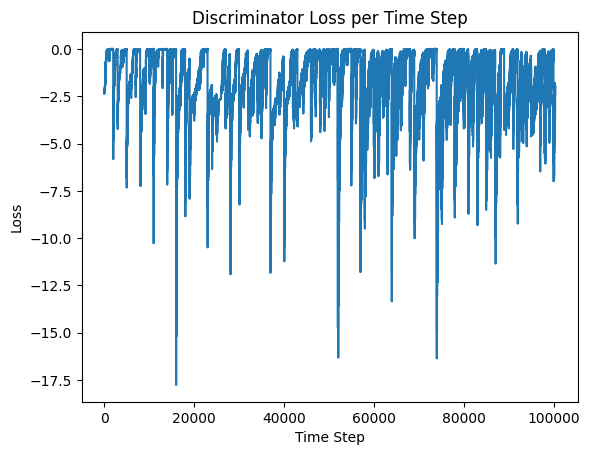

In [10]:
import matplotlib.pyplot as plt

plt.plot(all_loss)
plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Discriminator Loss per Time Step')
plt.show()

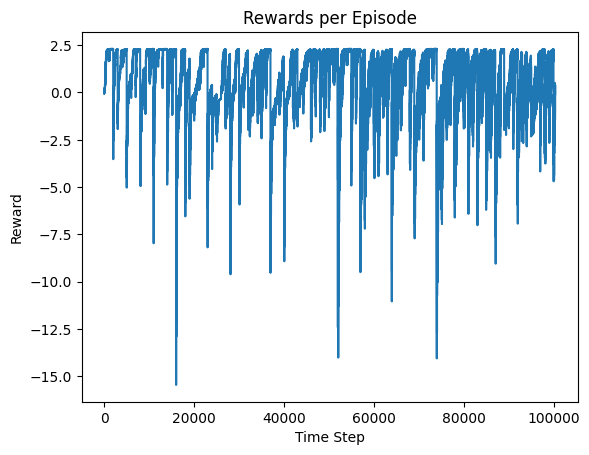

In [8]:
import matplotlib.pyplot as plt

plt.plot(all_rewards)
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Rewards per Time Step')
plt.show()

In [8]:
# Visualize model running

model = PPO.load("diayn_ppo_cheetah_big2")
env = gym.make("HalfCheetah-v4", render_mode="human")
env = CustomEnvWrapper(env)

obs, _ = env.reset()
print(env.cur_skill())
# env.skill = env.skill_dist.sample() # Replace <desired_skill> with the skill you want to use
rewards_all = []
for i in range(10000):
    if (i % 1000 == 0):
        obs, _ = env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info, _ = env.step(action)
    rewards_all.append(rewards)
    # env.render()

    if dones:
        break  

0


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [9]:
# Record trajectories
num_eval_episodes = NUM_SKILLS

model = PPO.load("diayn_ppo_cheetah_big")

env = gym.make("HalfCheetah-v4", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cheetah-diayn-big2", name_prefix="eval",
                  episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env)
env = CustomEnvWrapper(env)

for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    env.skill = torch.tensor(episode_num)
    print(env.cur_skill())

    episode_over = False
    while not episode_over:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

0
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-0.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-0.mp4
1
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-1.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-1.mp4
2
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-2.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-2.mp4
3
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-3.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-3.mp4
4
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-4.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-4.mp4
5
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-5.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-5.mp4
6
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-6.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-6.mp4
7
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-7.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-7.mp4
8
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-8.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-8.mp4
9
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-9.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-9.mp4



/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.time_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_queue` for environment variables or `env.get_wrapper_attr('time_queue')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big2/eval-episode-9.mp4


AttributeError: 'HalfCheetahEnv' object has no attribute 'time_queue'

In [11]:
# Graph trajectories

model = PPO.load("diayn_ppo_cheetah_big")

env = gym.make("HalfCheetah-v4", exclude_current_positions_from_observation=False) 
env = CustomEnvWrapper(env)

num_eval_episodes = 10

trajectories_x = []
trajectories_z = []

all_obs = []

skills = []

for skill in range(NUM_SKILLS):
    for episode_num in range(num_eval_episodes):
        trajectory_x = []
        trajectory_z = []
        obs_ = []
        obs, info = env.reset()
        env.skill = torch.tensor(skill)

        # trajectory_x.append(obs[:-1])
        # trajectory_z.append(obs[0])
        obs_.append(obs)
        obs = obs[:-1]
        skills.append(env.cur_skill())

        print(env.cur_skill())

        episode_over = False
        while not episode_over:
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            # trajectory_x.append(obs[:-1])
            # trajectory_z.append(obs[0])
            obs_.append(obs)
            obs = obs[:-1]

            episode_over = terminated or truncated

        # trajectories_x.append(trajectory_x)
        # trajectories_z.append(trajectory_z)
        all_obs.append(obs_)
    
env.close()

0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9


In [29]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    skill_mean = np.mean(skill_obs, axis=0)
    skill_var = np.var(skill_obs, axis=0)

    mean_list.append(skill_mean)
    variance_list.append(skill_var)

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

[8.64337758e-01 3.35928072e-03 5.71762943e-01 1.03213528e-04
 1.67677361e-05 2.18347746e-05 1.49039878e-04 2.83070009e-05
 5.67559895e-06 6.27686484e-04 4.14094384e-05 4.53549865e-04
 3.51262890e-05 1.67266634e-04 9.06410392e-05 8.38342570e-05
 2.10173201e-04 1.63975790e-04 8.23261700e+00]


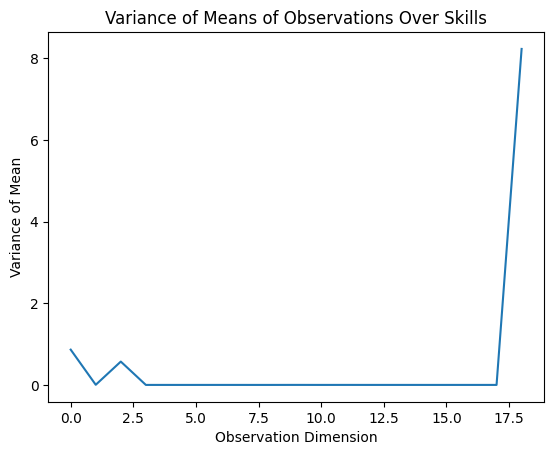

In [44]:
mean_list_ = np.var(mean_list, axis=0)
print(mean_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Mean')
plt.title('Variance of Means of Observations Over Skills')
plt.plot(mean_list_)

[1.48409197e+01 6.75675795e-05 3.74606631e+00 2.42862209e-06
 5.22401409e-06 1.42818634e-06 7.72739381e-06 4.76355361e-06
 1.99424796e-06 1.46626430e-03 2.37343321e-03 2.38029117e-02
 5.30883333e-01 1.46214991e+00 1.26842732e+00 1.66471487e+00
 5.12902207e+00 1.05953998e+00 6.82889046e-05]


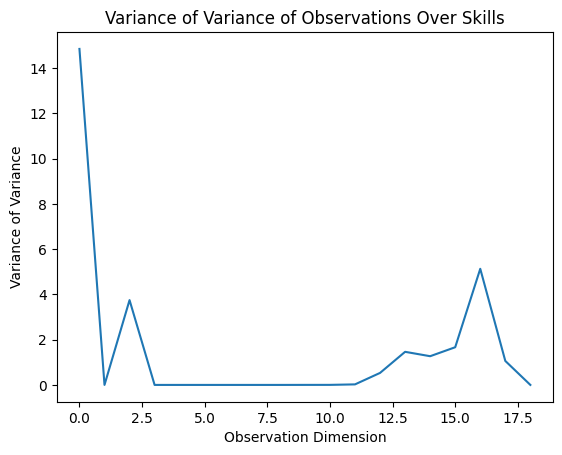

In [43]:
variance_list_ = np.var(variance_list, axis=0)
print(variance_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Variance')
plt.title('Variance of Variance of Observations Over Skills')
plt.plot(variance_list_)

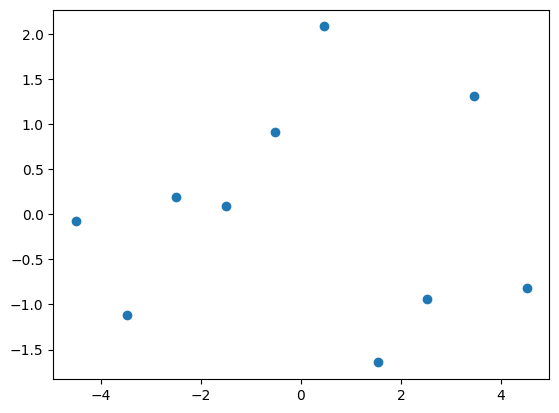

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(mean_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

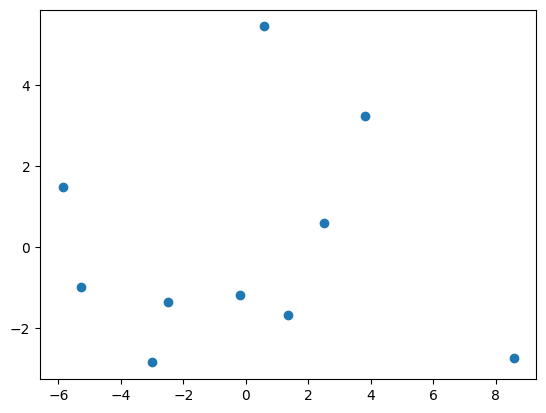

In [27]:
ca = PCA(n_components=2)
out = pca.fit_transform(variance_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

In [ ]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

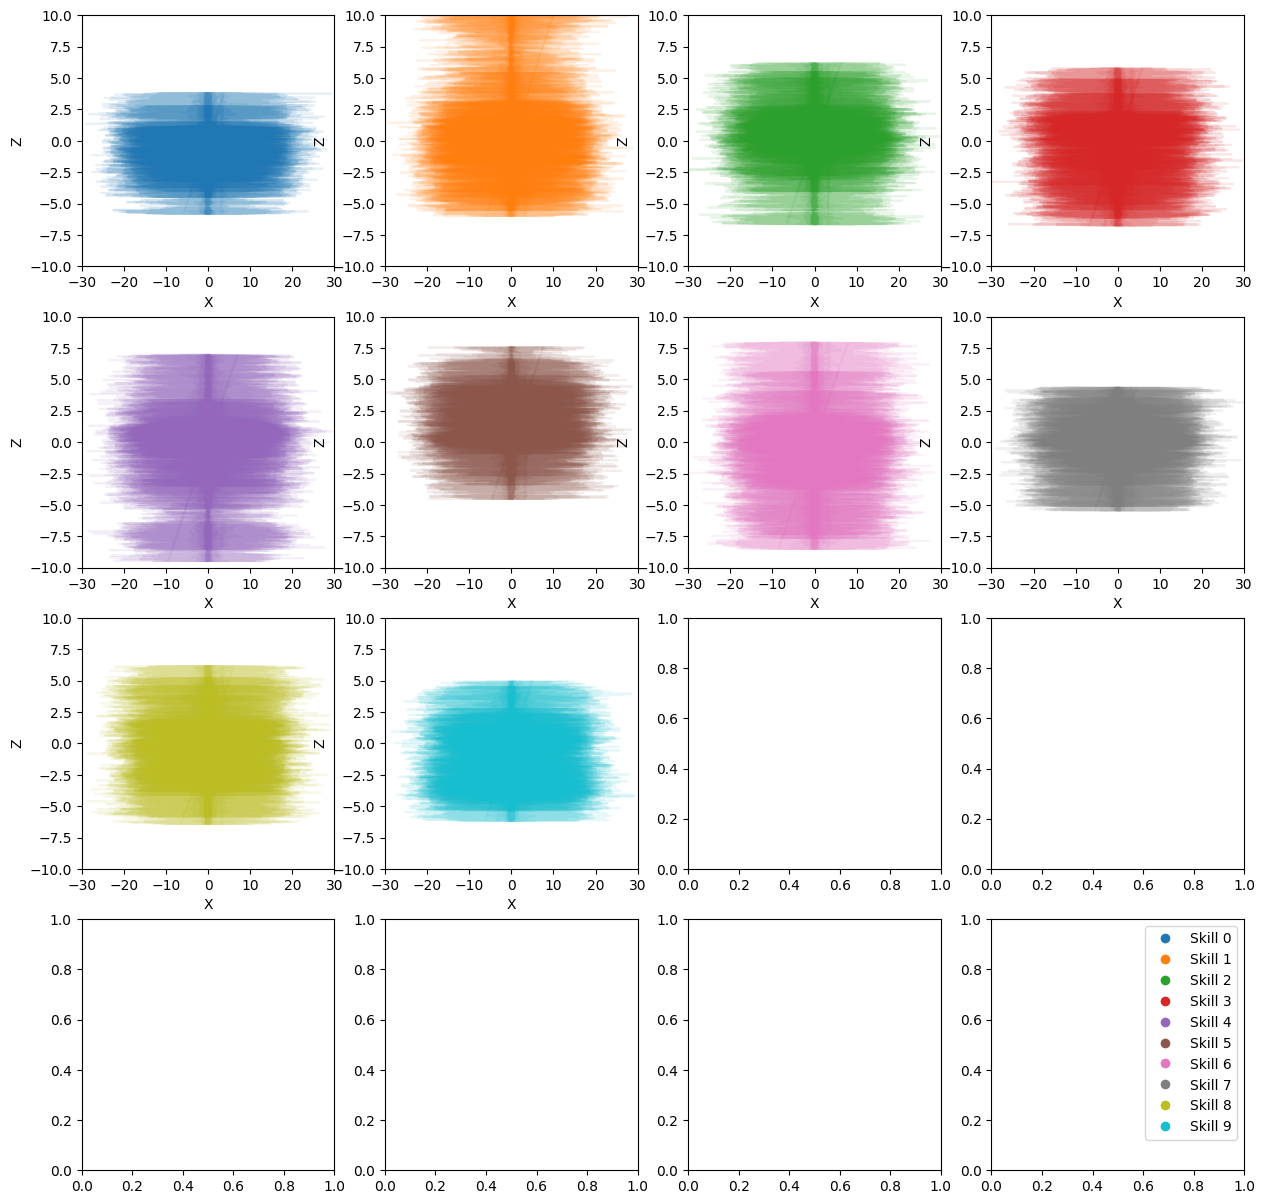

In [20]:
import matplotlib.pyplot as plt

# Create a color map for different skill indices
cmap = plt.get_cmap('tab10')

grid_size = int(np.ceil(np.sqrt(NUM_SKILLS)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Plot each trajectory with a different color based on skill index
for j in range(NUM_SKILLS):
    ax = axs[j // grid_size, j % grid_size]
    for i in range(num_eval_episodes):
        # i = 6
        k = j * NUM_SKILLS + i
        skill_index = skills[k]
        color = cmap(skill_index)
        ax.set_xlim(-30, 30)
        ax.set_ylim(-10, 10)
        # print(len(trajectories_x[i]), len(trajectories_z[i]))
        ax.plot(trajectories_x[k], trajectories_z[k], color=color, alpha=0.1)
        # plt.show()
        # break
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    # plt.title('Trajectories Heatmap')
    # plt.show()


# Set labels and title

# Show the legend for skill indices
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Skill {i}', markerfacecolor=cmap(i), markersize=8) for i in range(NUM_SKILLS)]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()